In [16]:
!pip install -q -r requirments.txt

### 1. Import Dependencies

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from enum import Enum
from pydantic import BaseModel
from dotenv import load_dotenv
import openai, groq
import os

load_dotenv()

True

In [18]:
import os
groq_api_key = os.getenv("GROQ_API_KEY")

# Check if the key is loaded properly
if not groq_api_key:
    print("API key not found in environment variables")
else:
    print(f"API key loaded: {groq_api_key[:10]}...")  # Show first 10 chars only

API key loaded: your_key...


### 2. Basic Information

In [19]:
os.getcwd()

'c:\\Users\\Hello\\Desktop\\Projects\\Machine Learning\\ML Course - Real World Applications\\GitHub\\Building-Production-Ready-Machine-Learning-System\\Week 01'

In [20]:
df = pd.read_csv('data/raw/ChurnModelling.csv') ## df - data frame
df.head(10)

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,NaN,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Jack,Smith,645,Spain,Male,44.0,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Carol,Wilson,822,France,Male,50.0,7,0.00,2,1,1,10062.80,0
7,8,15656148,Grace,Wilson,376,Germany,Female,29.0,4,115046.74,4,1,0,119346.88,1
8,9,15792365,Hank,Jones,501,France,Male,44.0,4,142051.07,2,0,1,74940.50,0
9,10,15592389,Eva,Wilson,684,France,Male,27.0,2,134603.88,1,1,1,71725.73,0


In [21]:
# Nan = not a Number

In [22]:
# get null values
df.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                600
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### 3. Handle Missing Value

#### 3.1 Deletion

**axis = 1** check each column and drop is a null value exist </br>
**axis = 0** check each column and drop is a null value exist

In [23]:
df_cp = df.copy()
df_cp.head()
df_cp = df_cp.dropna(axis =0)
df_cp.head()

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Jack,Smith,645,Spain,Male,44.0,8,113755.78,2,1,0,149756.71,1


#### 3.2 Imputation

##### 3.2.1 Age

In [24]:
mean = df['Age'].mean()
median = df['Age'].median()
mean = round(mean, 2)
print(f"Mean | Age = {mean}")
print(f"Median | Age = {median}")

Mean | Age = 38.91
Median | Age = 37.0


<Axes: xlabel='Age', ylabel='Count'>

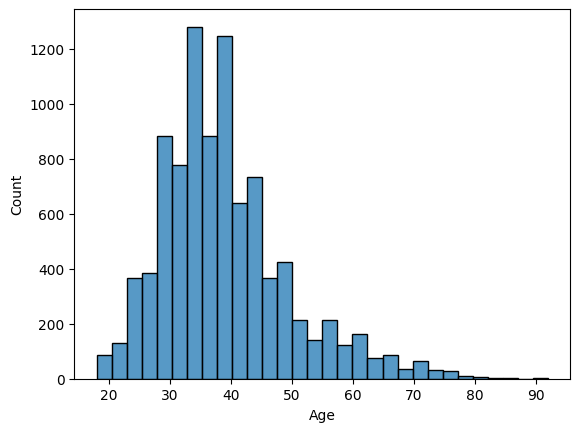

In [25]:
sns.histplot(df['Age'], bins=30)

In [26]:
df_impute = df.copy()

In [27]:
df_impute.loc[:, 'Age'] = df_impute['Age'].fillna(mean)
df_impute.head()

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.00,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.00,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,38.91,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0


In [28]:
df_impute.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

##### 3.2.2 Gender

In [29]:
class Gender(str, Enum):
    MALE = "Male"
    FEMALE = "Female"

# print(Gender.MALE.value)

class GenderPrediction(BaseModel):
    firstname: str
    lastname: str
    pred_gender: Gender

def predict_gender(
                firstname: str,
                lastname: str
                ):
    # Check if API key is available
    groq_api_key = os.getenv('GROQ_API_KEY')
    if not groq_api_key:
        raise ValueError("GROQ_API_KEY not found in environment variables. Please set it in your .env file.")
    
    prompt = f"""

            What is the most likely gender (Male or Female) for someone with the firstname '{firstname}'
            lastname '{lastname}' ?

            Your response only consists of one word: Male or Female
            """
    
    # Initialize Groq client with API key
    client = groq.Groq(api_key=groq_api_key)
    
    response = client.chat.completions.create(
                                                    model="llama-3.3-70b-versatile",
                                                    messages=[{
                                                        "role": "user",
                                                        "content": prompt
                                                    }]
                                                )
    
    predict_gender = response.choices[0].message.content.strip()
    return predict_gender

In [30]:
missing_gender_index = df_impute['Gender'].isnull()

for idx in df_impute[missing_gender_index].index:
    firstname = df_impute.loc[idx, 'Firstname']
    lastname = df_impute.loc[idx, 'Lastname']
    gender = predict_gender(firstname, lastname)
    if gender:
        df_impute.loc[idx, 'Gender'] = gender
        print(f"{firstname} {lastname} : {gender}")
    else:
        print(f"{firstname} {lastname} : No gender detected")

AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

In [ ]:
df_impute.isnull().sum()

RowNumber          0
CustomerId         0
Firstname          7
Lastname           6
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
df_impute = df_impute.drop(
    columns=[
        'RowNumber',
        'CustomerId',
        'Firstname',
        'Lastname'
    ]
)

df_impute.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.00,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42.00,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,38.91,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0


In [ ]:
df_impute.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
df_impute.to_csv('data/processed/ChurnModelling_imputed.csv', index=False)